# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [38]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline



# 读取MINST图形文件

In [39]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')
print(train_data_filename, train_labels_filename, test_data_filename, test_labels_filename)

# train_data_filename = './data/train-images-idx3-ubyte.gz'
# train_labels_filename = './data/train-labels-idx1-ubyte.gz'
# test_data_filename = './data/t10k-images-idx3-ubyte.gz'
# test_labels_filename = './data/t10k-labels-idx1-ubyte.gz'

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels
test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels
train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

data/train-images-idx3-ubyte.gz data/train-labels-idx1-ubyte.gz data/t10k-images-idx3-ubyte.gz data/t10k-labels-idx1-ubyte.gz
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


((60000, 784), (60000,))

In [40]:
print(train_labels)
print(len(train_labels))

[5 0 4 ..., 5 6 8]
60000


# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [53]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
#  下面7%的错误率是基于此结果跑的，想减少大矩阵运算，但是结果不怎么好
# net = torch.nn.Sequential(
#     torch.nn.Linear(784, 10),
#     torch.nn.Sigmoid(),
#     torch.nn.Linear(10, 10),
#     torch.nn.Sigmoid(),
#     torch.nn.Sigmoid(),
#     torch.nn.Linear()
# )

# 问题：如果要增加新的神经网络层怎么办？
net = torch.nn.Sequential(
    torch.nn.Linear(784, 10),
    torch.nn.Sigmoid(),
    torch.nn.Sigmoid(),
    torch.nn.Sigmoid(),
    torch.nn.Sigmoid(),
    torch.nn.Sigmoid(),
    torch.nn.Sigmoid(),
    torch.nn.Linear(10, 10)
)

### 第二步：构造损失函数和优化器

In [54]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [56]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
    predictions = np.argmax(predictions, 1)
    return 100.0 - (100.0 * np.sum(predictions == labels) / predictions.shape[0])

# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环

losses = []
errors = []
# 神经网络训练循环
batch_size = 128
for i in range(1000):
#     每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
   batch_loss = []
   batch_error = []
#     start和end分别是提取一个batch数据的起始和终止下标
   for start in range(0, len(train_X), batch_size):
       end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
       xx = Variable(torch.FloatTensor(train_X[start:end])) #从训练数据train_X中提取数据
       yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
       predict = net(xx) #用神经网络进行预测
       loss = cost(predict, yy) #计算损失函数（交叉熵）
       err = error_rate(predict.data.numpy(), yy.data.numpy())
   
       optimizer.zero_grad() #清空梯度
       loss.backward() #开始反向传播
       optimizer.step() #开始更新梯度
       batch_loss.append(loss.data.numpy())
       batch_error.append(err)
    
#     每隔100步输出一下损失值（loss）
   if i % 100==0:
       losses.append(np.mean(batch_loss))
       errors.append(np.mean(batch_error))
       print(i, np.mean(batch_loss), np.mean(batch_error))

0 0.14589 3.8934790334
100 0.14289 3.80907960199
200 0.140283 3.72079335466
300 0.137955 3.63917022033
400 0.135796 3.57753642502
500 0.133719 3.52589729922
600 0.131822 3.49258173419
700 0.130159 3.43427949538
800 0.128666 3.37875355366
900 0.127379 3.32211709311


### 请在这里写下你自己的回答

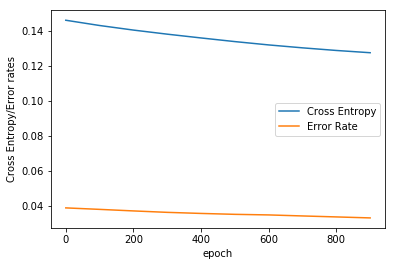

In [57]:

# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！
plt.plot(np.arange(len(losses))*100, losses, label='Cross Entropy')
plt.plot(np.arange(len(losses))*100, np.array(errors) / float(100), label='Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error rates')
plt.legend()

### 第四步：在测试集上测试模型

In [58]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
#def error_rate(predictions, labels):
#    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
#    predictions = np.argmax(predictions, 1)
#    return 100.0 - (
#      100.0 *
#      np.sum( predictions == labels) /
#      predictions.shape[0])

In [59]:
# 分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
   end = start + batch_size if start + batch_size < len(test_X) else len(test_X)
   i += 1
   x = Variable(torch.FloatTensor(test_X[start:end]))
   y = Variable(torch.LongTensor(test_Y[start:end]))
   predictions = net(x)
   loss = cost(predictions, y)
   err_rate = error_rate(predictions.data.numpy(), y.data.numpy())
   errors.append(err_rate)
   losses.append(loss.data.numpy())
   print(i, err_rate)

print('平均错误率：%.4f%%'%np.mean(errors))

1 5.46875
2 6.25
3 9.375
4 10.9375
5 11.71875
6 8.59375
7 10.9375
8 8.59375
9 5.46875
10 17.1875
11 6.25
12 14.84375
13 8.59375
14 9.375
15 10.9375
16 9.375
17 15.625
18 7.03125
19 14.0625
20 4.6875
21 14.84375
22 8.59375
23 9.375
24 14.84375
25 7.8125
26 10.15625
27 10.15625
28 8.59375
29 9.375
30 16.40625
31 10.9375
32 10.15625
33 11.71875
34 10.9375
35 10.15625
36 8.59375
37 6.25
38 11.71875
39 13.28125
40 3.125
41 7.03125
42 2.34375
43 2.34375
44 3.90625
45 9.375
46 3.90625
47 8.59375
48 9.375
49 4.6875
50 2.34375
51 3.90625
52 18.75
53 6.25
54 2.34375
55 0.78125
56 0.78125
57 5.46875
58 3.90625
59 8.59375
60 0.78125
61 0.78125
62 11.71875
63 4.6875
64 3.125
65 10.9375
66 6.25
67 3.125
68 0.0
69 0.0
70 2.34375
71 9.375
72 4.6875
73 2.34375
74 4.6875
75 7.03125
76 10.9375
77 16.40625
78 8.59375
79 6.25
平均错误率：7.8619%


### 用单个图像进行测试

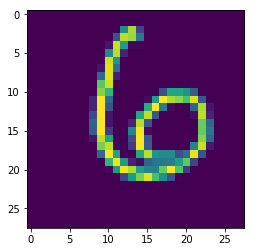

In [60]:
#随便从数据集中读入一张图片，并绘制出来
idx = 100
muteimg = test_data[idx, 0, :, :]
plt.imshow(muteimg)

In [61]:
# 计算识别结果
x = Variable(torch.FloatTensor(test_X[idx, :].reshape(1, -1)))
predict = net(x)
np.argmax(predict.data.numpy())

6

## 升级版

如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码